[View in Colaboratory](https://colab.research.google.com/github/Masum06/gender_mining/blob/master/char_rnn_hsc_data.ipynb)

###Down From Mega

In [1]:
%%bash
git clone https://github.com/jeroenmeulenaar/python3-mega.git python3mega
cd python3mega
pip install -r requirements.txt

  Running setup.py bdist_wheel for URLObject: started
  Running setup.py bdist_wheel for URLObject: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/fd/7e/18/ccb55ecc2834f945b769c1ff1df12ca5a14400ccfc58e3c515
  Running setup.py bdist_wheel for pycrypto: started
  Running setup.py bdist_wheel for pycrypto: finished with status 'done'
  Stored in directory: /content/.cache/pip/wheels/27/02/5e/77a69d0c16bb63c6ed32f5386f33a2809c94bd5414a2f6c196
Successfully built URLObject pycrypto


Cloning into 'python3mega'...
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [0]:
import os
os.chdir('python3mega')
from mega import Mega
m = Mega.from_ephemeral()
os.chdir('..')

In [0]:
m.download_from_url('https://mega.nz/#!RQgxjTDR!vrQimln7Yvtxgn6lqSmKWW1CAWFmSCM2JbWsQcT9ptA') # HSC Name dataset

In [4]:
!ls

datalab  hsc_name_gender.csv  python3mega


### Character RNN

In [5]:
# https://keras.io/
!pip install -q keras
!pip install scikit-learn
!pip install matplotlib

You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 10.0.1, however version 18.0 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [6]:
%matplotlib inline
import itertools
import keras
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [0]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [0]:
import pandas as pd
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding, Bidirectional
from keras.layers import LSTM, GRU
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

fileName = './hsc_name_gender.csv'

# Lowering the texts and replacing with numeral value
df = pd.read_csv(fileName, encoding='utf-8')
df.columns = ['name', 'gender']
df['name'] = df['name'].str.lower()

df = df.dropna()
df = df.drop_duplicates()

# Getting all available strings to find out the characters used
all_string = " ".join([name for name in df['name']])
unique_characters = list(set(list(all_string)))

# Mapping between character to index and index to character
char2idx = { c : i for i, c in enumerate(unique_characters) }
idx2char = {c: k for k, c in char2idx.items()}

# Converts a name into vector
def name2vector(name):
    chars = list(name)
    vector = [ char2idx[c] for c in chars ]
    return np.array(vector)

# Converts names to fixed size tensor
def names2tensor(names, maxlen=25):
    namelist = [name2vector(name) for name in names]
    return sequence.pad_sequences(np.array(namelist), maxlen=maxlen)  # root of all troubles

Preparing dataset

In [0]:
# train dataset
X = np.array(names2tensor(df['name'], maxlen=25)) #
Y = np.array([int(g) for g in df['gender']])

X, Y = shuffle(X, Y, random_state=42)

x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.3) #changed

Setting up parameters

In [0]:
# max features
max_features = 20000
batch_size = 32
epochs = 1

### Building Model

In [0]:
# Model building and training
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 128))
model.add(LSTM(128, dropout=0.5, recurrent_dropout=0.5)) #changed
model.add(Dense(1, activation='sigmoid'))

# try using different optimizers and different optimizer configs
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy']             
             )

Autosaving models parameters

In [0]:
filepath="weights-improvement-{epoch:02d}-{val_acc:.4f}.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
callbacks_list = [checkpoint]

### Train

In [30]:
print('Train...')
model.fit(x_train, y_train,batch_size=batch_size, epochs=epochs, callbacks=callbacks_list, validation_data=(x_test, y_test))

Train...
Train on 2121126 samples, validate on 909055 samples
Epoch 1/1
   3328/2121126 [..............................] - ETA: 1:35:31 - loss: 0.6767 - acc: 0.6836

KeyboardInterrupt: ignored

In [0]:
i = 4

model.save('char_rnn_hsc_model_{}.h5'.format(i))

In [20]:
!curl --upload-file ./char_rnn_hsc_model_2.h5 https://transfer.sh/char_rnn_hsc_model_2.h5

https://transfer.sh/xvS43/char_rnn_hsc_model_2.h5

In [30]:
ls

char_rnn_hsc_model_1.h5  datalab/             python3mega/
char_rnn_hsc_model_2.h5  drive/               weights-improvement-01-0.97.hdf5
char_rnn_hsc_model_3.h5  hsc_name_gender.csv  weights-improvement-01-0.98.hdf5




*   https://transfer.sh/AqEf7/char_rnn_hsc_model_1.h5: 97.45
*   https://transfer.sh/xvS43/char_rnn_hsc_model_2.h5: 97.55
*   char_rnn_hsc_model_3.h5: 97.61



###Connect to drive, save the model

In [11]:
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!apt-get -y install -qq google-drive-ocamlfuse fuse
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
··········
Please, open the following URL in a web browser: https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&response_type=code&access_type=offline&approval_prompt=force
Please enter the verification code: Access token retrieved correctly.


In [0]:
!mkdir -p drive
!google-drive-ocamlfuse drive

### Save Model

In [0]:
!cp char_rnn_hsc_model_4.h5 drive/deeper/data/char_rnn_hsc_models/

###Load model and run

In [0]:
!cp drive/deeper/data/char_rnn_hsc_models/char_rnn_hsc_model_3.h5 ./

In [0]:
#model.load_weights('char_rnn_hsc_model_3.h5')

In [0]:
# LOAD SAVED MODEL
from keras.models import load_model

#del model  # deletes the existing model
model = load_model('char_rnn_hsc_model_3.h5')

###Dataframe

In [10]:
df.head

<bound method NDFrame.head of                       en_name  gender
0                  saju ahmed       1
1              md martuj  ali       1
2                rushna begum       0
3                nazira akter       0
4                    ali miah       1
5                 saira begum       0
6              khaled hossain       1
7              md jamal uddin       1
8                 rajna begum       0
9                shanta akter       0
10                ahsan uddin       1
11               latifa begum       0
12              sokhina begum       0
13                tajul islam       1
14               forida begum       0
15               ariful islam       1
16               azizul haque       1
17               fatema begum       0
18           md jakirul islam       1
19              md abu siddik       1
20               majeda begum       0
21               shuva  begum       0
22                badsha miah       1
23               hakima begum       0
24               azi

In [12]:
len(df.drop_duplicates())

3030181

In [13]:
len(df)

13565233

###Testing

In [22]:
y_pred = np.array([y[0] for y in model.predict_classes(x_test)])

KeyboardInterrupt: ignored

In [20]:
print(df['name'])

0                          saju ahmed
1                      md martuj  ali
2                        rushna begum
3                        nazira akter
4                            ali miah
5                         saira begum
6                      khaled hossain
7                      md jamal uddin
8                         rajna begum
9                        shanta akter
10                        ahsan uddin
11                       latifa begum
12                      sokhina begum
13                        tajul islam
14                       forida begum
15                       ariful islam
16                       azizul haque
17                       fatema begum
18                   md jakirul islam
19                      md abu siddik
20                       majeda begum
21                       shuva  begum
22                        badsha miah
23                       hakima begum
24                       azizul hakim
25                          anjob ali
26          

In [21]:
print(idx2char)

{0: '_', 1: '{', 2: 'u', 3: 'x', 4: "'", 5: '|', 6: 'ÿ', 7: 'i', 8: '"', 9: '/', 10: '2', 11: ' ', 12: '0', 13: '\t', 14: 'j', 15: 'm', 16: '(', 17: '9', 18: ':', 19: '*', 20: '}', 21: 'd', 22: 'o', 23: 'v', 24: '.', 25: 'b', 26: '¨', 27: '\x96', 28: '3', 29: 'r', 30: 't', 31: '-', 32: '\\', 33: 's', 34: 'p', 35: '5', 36: '8', 37: '\x83', 38: 'l', 39: 'e', 40: 'q', 41: '>', 42: '=', 43: ')', 44: 'h', 45: 'y', 46: '`', 47: '7', 48: 'z', 49: 'c', 50: '[', 51: 'g', 52: '4', 53: 'a', 54: 'k', 55: '6', 56: 'n', 57: 'f', 58: ']', 59: '+', 60: ';', 61: 'w', 62: '1', 63: '?'}


In [22]:
X1 = np.array(names2tensor(df['name']))
print(names2tensor(df['name']))

[[ 0  0  0 ... 15 39 21]
 [ 0  0  0 ... 53 38  7]
 [ 0  0  0 ... 51  2 15]
 ...
 [ 0  0  0 ... 61 53 56]
 [ 0  0  0 ... 29 15  7]
 [ 0  0  0 ... 53 56  2]]


In [15]:
print(y_train.shape)
print(char2idx)
print(len(char2idx))
print(idx2char)
for i in range(10):
  for x in names2tensor(df['name'])[i]:
    print(idx2char[x], end="")
  print()

(2121126,)
{'h': 0, '+': 1, '0': 2, 'b': 3, 'u': 4, '6': 5, '"': 6, '5': 7, '8': 8, 'i': 9, 'n': 10, '|': 11, '\\': 12, '/': 13, 't': 14, 'o': 15, ')': 16, '2': 17, '(': 18, 'w': 19, '3': 20, '*': 21, '¨': 22, ':': 23, 'd': 24, '`': 25, 'a': 26, '4': 27, '>': 28, 'j': 29, '-': 30, '.': 31, ';': 32, 'm': 33, "'": 34, '{': 35, 'ÿ': 36, '=': 37, 'g': 38, 'v': 39, '_': 40, 'c': 41, 'k': 42, 'f': 43, '7': 44, '\x83': 45, '[': 46, 'l': 47, '9': 48, 'y': 49, 'e': 50, '?': 51, 'z': 52, ' ': 53, '\x96': 54, 'q': 55, '1': 56, 'p': 57, 'x': 58, '\t': 59, 'r': 60, ']': 61, '}': 62, 's': 63}
64
{0: 'h', 1: '+', 2: '0', 3: 'b', 4: 'u', 5: '6', 6: '"', 7: '5', 8: '8', 9: 'i', 10: 'n', 11: '|', 12: '\\', 13: '/', 14: 't', 15: 'o', 16: ')', 17: '2', 18: '(', 19: 'w', 20: '3', 21: '*', 22: '¨', 23: ':', 24: 'd', 25: '`', 26: 'a', 27: '4', 28: '>', 29: 'j', 30: '-', 31: '.', 32: ';', 33: 'm', 34: "'", 35: '{', 36: 'ÿ', 37: '=', 38: 'g', 39: 'v', 40: '_', 41: 'c', 42: 'k', 43: 'f', 44: '7', 45: '\x83', 46

In [0]:
def nameTest(name):
  result = model.predict_classes(np.array(names2tensor([name])))[0][0]
  if result:
    print("Male")
  else:
    print("Female")

In [21]:
name = "zakaria"
nameTest(name)

Male


Confusion matrix, without normalization
[[ 76778 308320]
 [ 33673 490284]]


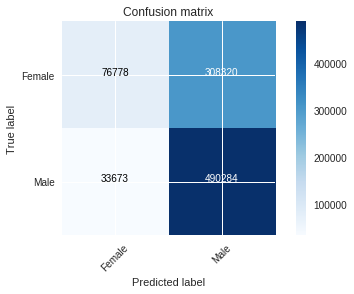

In [31]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred), classes=['Female', 'Male'], normalize=True)

In [32]:
y_train[y_train == 1.0].shape

(1222682,)